In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import spacy 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [151]:
nlp = spacy.load('en_core_web_sm')

In [152]:
#standardize
course_df = pd.read_csv("./coursedata/course_data.csv")

In [153]:
course_df.head(5)

,Unnamed: 0,code,name,description
0,0,CPSC_V 100,Computational Thinking,Meaning and impact of computational thinking. ...
1,1,CPSC_V 103,Introduction to Systematic Program Design,Computation as a tool for systematic problem s...
2,2,CPSC_V 107,Systematic Program Design,Fundamental computation and program structures...
3,3,CPSC_V 110,"Computation, Programs, and Programming",Fundamental program and computation structures...
4,4,CPSC_V 121,Models of Computation,Physical and mathematical structures of comput...


In [154]:
course_df.drop(columns=[course_df.columns[0]], inplace=True)

In [155]:
course_df.head()

,code,name,description
0,CPSC_V 100,Computational Thinking,Meaning and impact of computational thinking. ...
1,CPSC_V 103,Introduction to Systematic Program Design,Computation as a tool for systematic problem s...
2,CPSC_V 107,Systematic Program Design,Fundamental computation and program structures...
3,CPSC_V 110,"Computation, Programs, and Programming",Fundamental program and computation structures...
4,CPSC_V 121,Models of Computation,Physical and mathematical structures of comput...


In [156]:
course_df.fillna('', inplace=True)

In [157]:
course_df

,code,name,description
0,CPSC_V 100,Computational Thinking,Meaning and impact of computational thinking. ...
1,CPSC_V 103,Introduction to Systematic Program Design,Computation as a tool for systematic problem s...
2,CPSC_V 107,Systematic Program Design,Fundamental computation and program structures...
3,CPSC_V 110,"Computation, Programs, and Programming",Fundamental program and computation structures...
4,CPSC_V 121,Models of Computation,Physical and mathematical structures of comput...
...,...,...,...
105,CPSC_V 554,Topics in Human-Computer Interaction,This course is not eligible for Credit/D/Fail...
106,CPSC_V 564,Data Mining,This course is not eligible for Credit/D/Fail...
107,CPSC_V 589,M.Sc. Major Essay,This course is not eligible for Credit/D/Fail...
108,CPSC_V 590,Research Methods in Computer Science,This course is not eligible for Credit/D/Fail...


In [158]:
def clean_text(x):
    if x["description"].strip() == "This course is not eligible for Credit/D/Fail grading.":
        return x["name"]
    else:
        return x["description"]

course_df["description"] = course_df[["name", "description"]].apply(clean_text, axis=1)

In [159]:
import spacy
nlp = spacy.load('en_core_web_sm')

def related_courses(df):
    searched = set()
    #this takes all course codes
    for i in range(1,len(df["description"])):
        text = nlp(df["description"].iloc[i])
        for j in text.ents:
            if j.label_ == "ORG" and len(j.text) == 4:
                searched.add(j.text.upper())
    return searched

all_related_courses = related_courses(course_df)

In [160]:
all_related_courses.add("BIOL")
all_related_courses.add("APSC")
all_related_courses.add("COMM")
all_related_courses.add("MATH")

In [161]:
import re

pattern = r'Prerequisite|Corequisite|Not for students with existing credit for or exemption from | or currently enrolled in | Continuing .+ from | or are concurrently taking'

def return_related(phrase):
    words = set()
    split = re.split(pattern.upper(), phrase.upper())
    if len(split) > 1:
        for i in split[1:]:
            token_text = word_tokenize(i)
            for j in token_text:
                if j in all_related_courses:
                    j = "_".join((j, token_text[token_text.index(j)+1]))
                    words.add(j)
    else:
        return "NA"
    return " ".join(words)
course_df["prereq"] = course_df["description"].apply(return_related)

In [162]:
course_df["prereq"].iloc[1:10]

1                      APSC_160 CPSC_110
2                               CPSC_103
3                                     NA
4                               CPSC_107
5    MATH_210 CPSC_103 COMM_337 APSC_160
6                               CPSC_107
7                               CPSC_121
8                      MATH_220 CPSC_210
9                               APSC_160
Name: prereq, dtype: object

In [163]:
tfv =  TfidfVectorizer(stop_words='english', lowercase=True)
scaler = RobustScaler()

def vectorize(d, vec, s):
    # wl = WordNetLemmatizer()
    # d = wl.lemmatize(d)
    
    res =  vec.fit_transform(d)
    return s.fit_transform(res.toarray())

vectorized_description = vectorize(course_df["description"], tfv, scaler)

In [164]:
#For prereq
from sklearn.preprocessing import StandardScaler
prereq_vec = TfidfVectorizer(stop_words='english', lowercase=True)
prereq_scaler = StandardScaler()

vectorized_prereqs = vectorize(course_df[(course_df["prereq"] != " ")]["prereq"], prereq_vec, prereq_scaler)

In [165]:
tfv.get_feature_names_out()

array(['001', '101', '103', '105', '107', '110', '111', '12', '121',
       '152', '160', '200', '201', '203', '206', '210', '211', '212',
       '213', '217', '218', '220', '221', '223', '226', '231', '241',
       '250', '251', '253', '254', '259', '261', '278', '291', '300',
       '302', '303', '304', '307', '310', '311', '313', '314', '317',
       '318', '320', '321', '322', '325', '327', '328', '331', '337',
       '340', '344', '366', '371', '374', '380', '3d', '411', '491', '68',
       '72', 'abstraction', 'according', 'acquisition', 'action',
       'active', 'admitted', 'advanced', 'advisor', 'ai', 'algebra',
       'algebraic', 'algorithm', 'algorithmic', 'algorithms', 'alignment',
       'analysis', 'analytic', 'animation', 'annotation', 'application',
       'applications', 'applied', 'approach', 'approaches', 'appropriate',
       'approved', 'approximation', 'apsc', 'architecture',
       'architectures', 'area', 'areas', 'artificial', 'assessment',
       'associated'

In [166]:
prereq_vec.get_feature_names_out()

array(['apsc_160', 'biol_300', 'biol_beyond', 'bmeg_250', 'comm_291',
       'comm_337', 'cpsc_103', 'cpsc_107', 'cpsc_110', 'cpsc_121',
       'cpsc_203', 'cpsc_210', 'cpsc_213', 'cpsc_221', 'cpsc_302',
       'cpsc_304', 'cpsc_310', 'cpsc_313', 'cpsc_314', 'cpsc_320',
       'cpsc_322', 'cpsc_344', 'eece_259', 'geog_374', 'math_101',
       'math_152', 'math_200', 'math_210', 'math_220', 'math_307',
       'math_or', 'na', 'scie_001', 'stat_200', 'stat_241', 'stat_at'],
      dtype=object)

# Course Description

In [167]:
from sklearn.decomposition import PCA, KernelPCA

<Axes: >

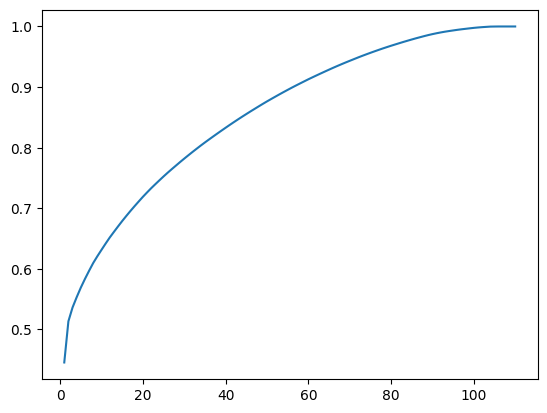

In [168]:
import numpy as np
pca_test = PCA(n_components=110)
pca_test.fit(vectorized_description)

sns.lineplot(x=[i for i in range(1,111)], y=np.cumsum(pca_test.explained_variance_ratio_))

In [169]:
ideal_comps = 65

In [170]:
pca = PCA(n_components=ideal_comps)
pca_description = pca.fit_transform(vectorized_description)

In [171]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

def pca_search(param):
    chs = {}
    chs["k"] = []
    chs["agg"] = []
    chs["spec"] = []


    for i in (range(2,20)):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500,random_state=18).fit(param)
        dbscan = DBSCAN(eps=0.5, min_samples=i).fit(param)
        agg = AgglomerativeClustering(n_clusters=i).fit(param)
        spec = SpectralClustering(n_clusters=i, affinity="nearest_neighbors").fit(param)
        
        chs["k"].append(calinski_harabasz_score(param,kmeans.labels_))
        chs["agg"].append(calinski_harabasz_score(param,agg.labels_))
        chs["spec"].append(calinski_harabasz_score(param,spec.labels_))
        
    
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    indices = np.arange(2,20,1)
    ax[0,0].plot(indices, list(chs["k"]), marker='o', color = 'red')
    ax[0,1].plot(indices, list(chs["agg"]), marker='o', color = 'green')
    ax[1,0].plot(indices, list(chs["spec"]), marker='o', color = 'yellow')
    
    fig.suptitle("Elbow Plot for various models - Clustering CPSC courses")
    fig.set_label("something")
    plt.show()

    pass

In [217]:
def return_optimal(optimal, param):
    label = optimal.fit_predict(param)
    #Getting the Centroids
    
    u_labels = np.unique(label)
    # # plotting the results:
    plt.figure() 
    for i in u_labels:
        plt.scatter(param[label == i , 0] , param[label == i , 1] , label = i)
    if type(optimal).__name__ == "KMeans":
        centroids = optimal.cluster_centers_
        plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()
    
    with_label = pd.concat([course_df, pd.DataFrame(label)], axis=1)
    return [optimal, with_label]

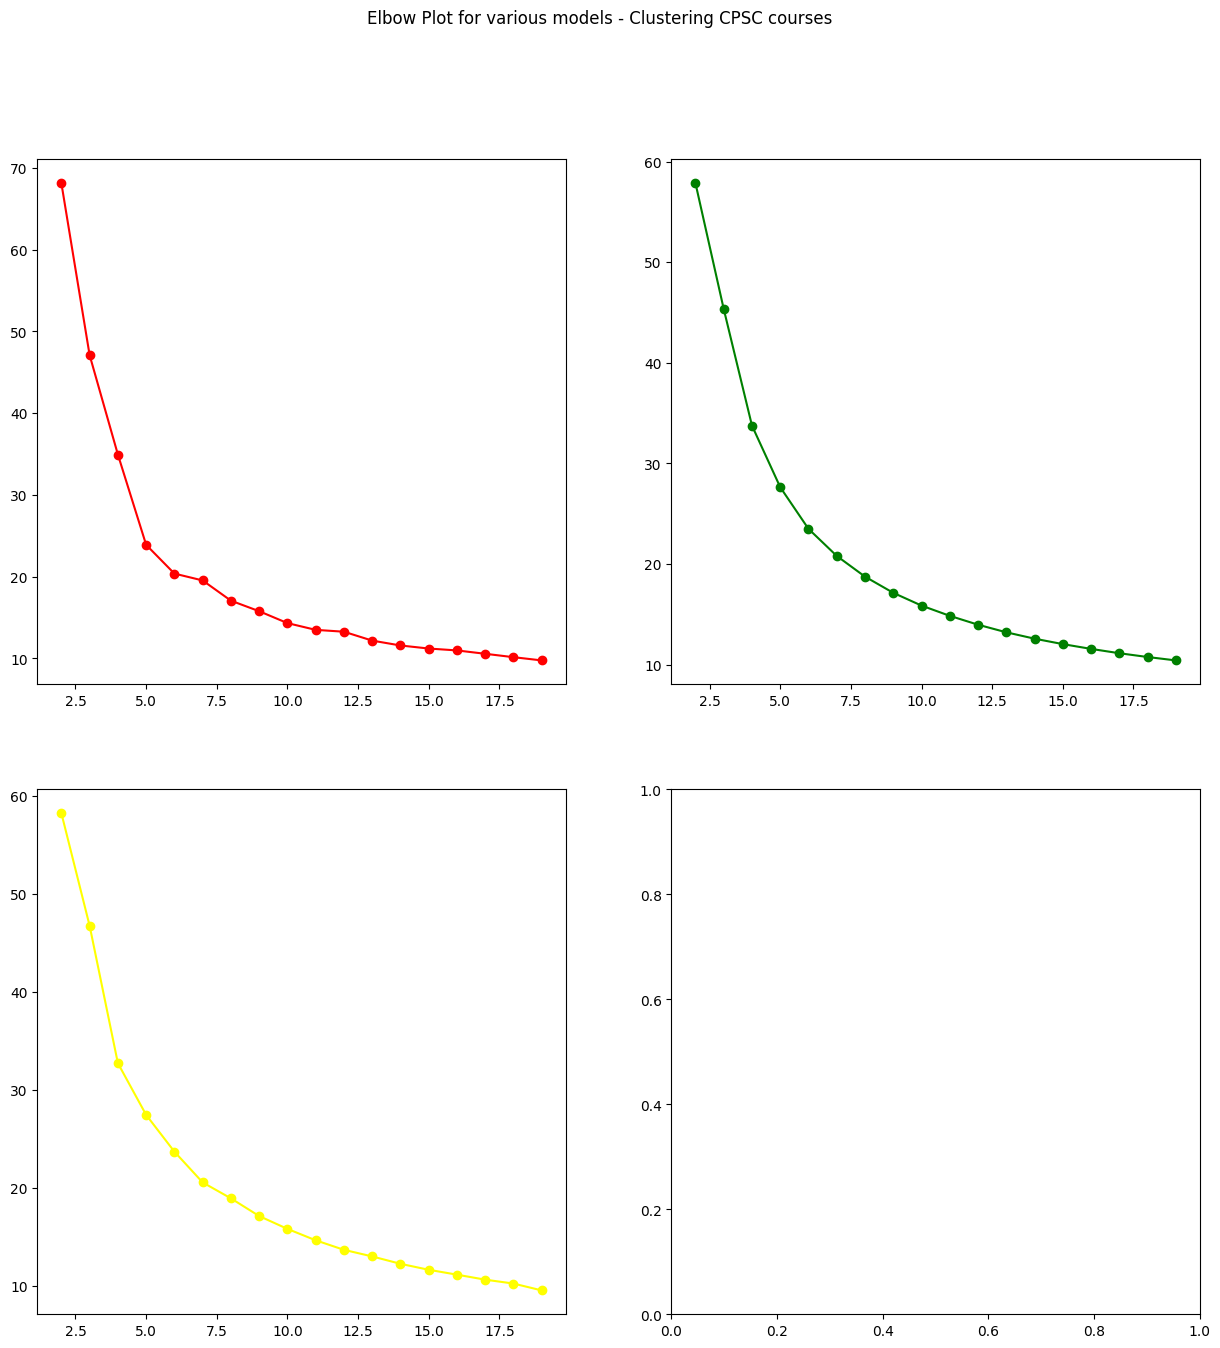

In [173]:
pca_search(pca_description)

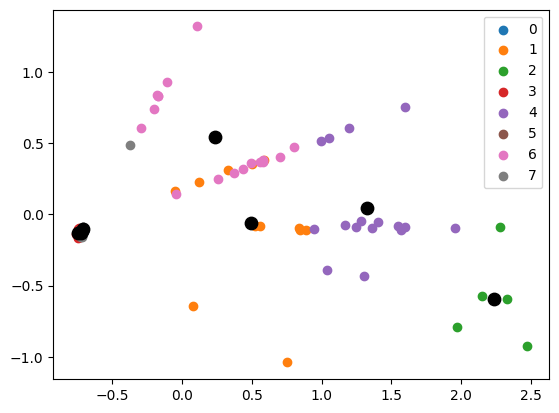

In [218]:
kmeans, with_label = return_optimal(KMeans(n_clusters = 8, init="k-means++", random_state=18, max_iter=500), pca_description)

In [175]:
pca_2 = KernelPCA(n_components=ideal_comps, kernel="rbf")
pca_description_2 = pca_2.fit_transform(vectorized_description)

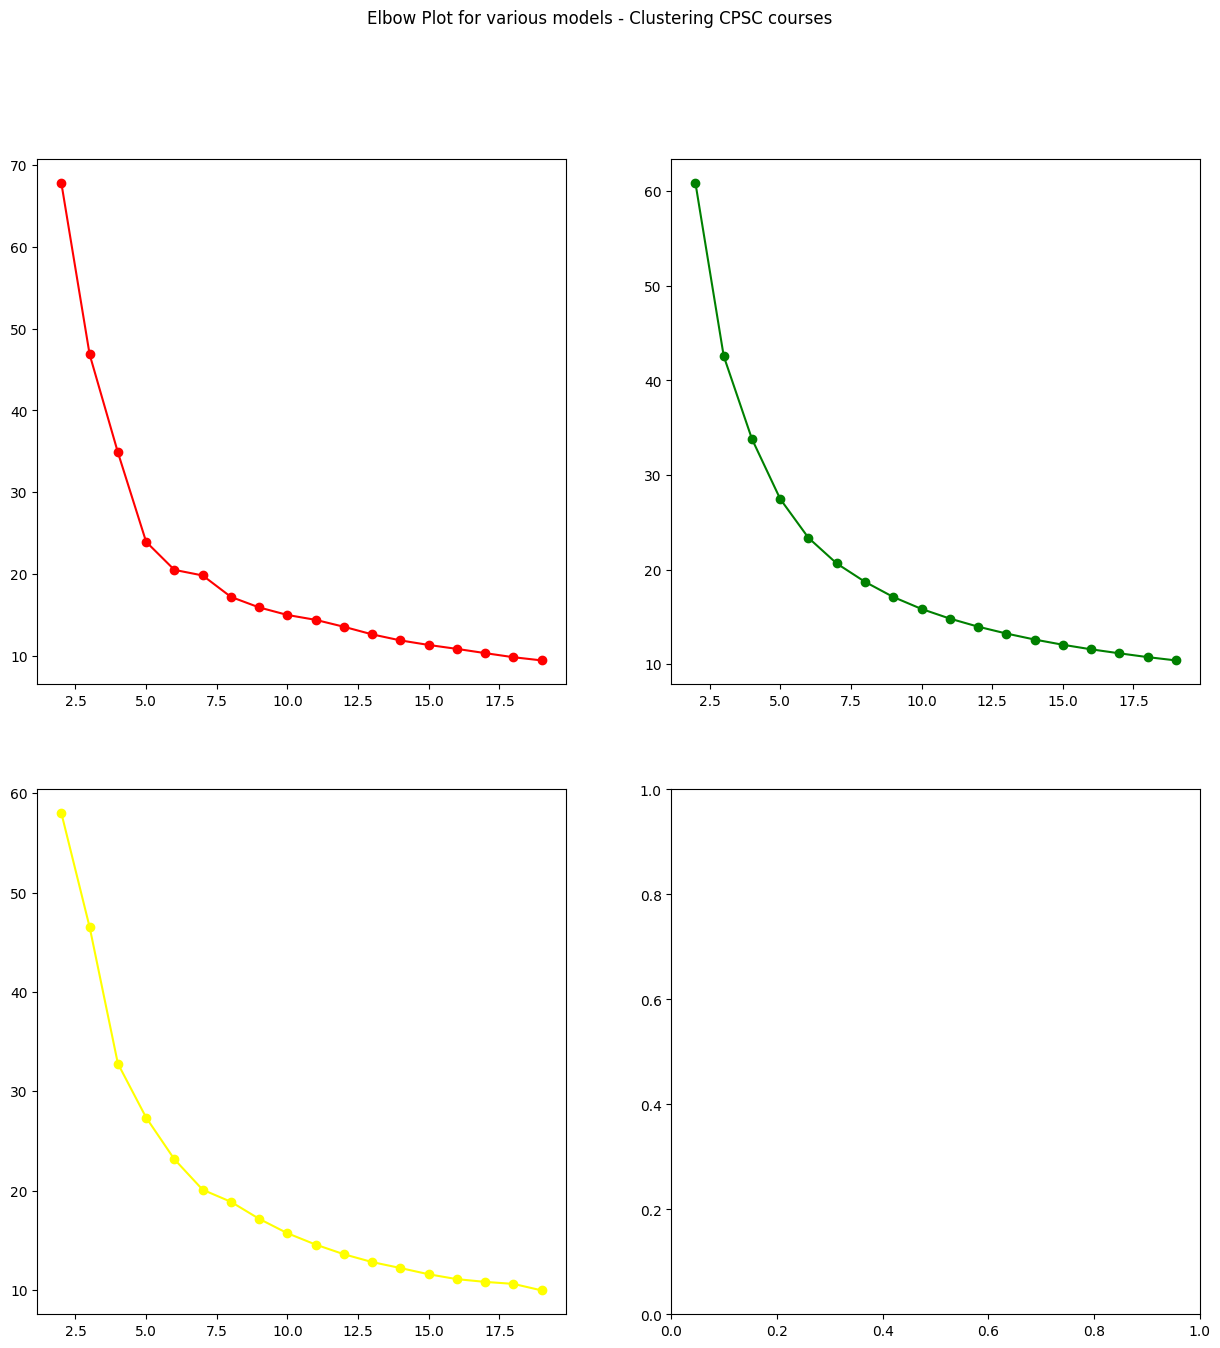

In [176]:
pca_search(pca_description_2)

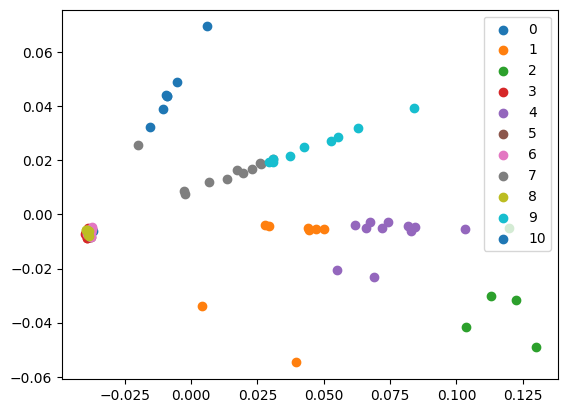

In [177]:
kmeans_2, with_label_2 = return_optimal(KMeans(n_clusters=11, random_state=18, init="k-means++", max_iter=1000), pca_description_2)

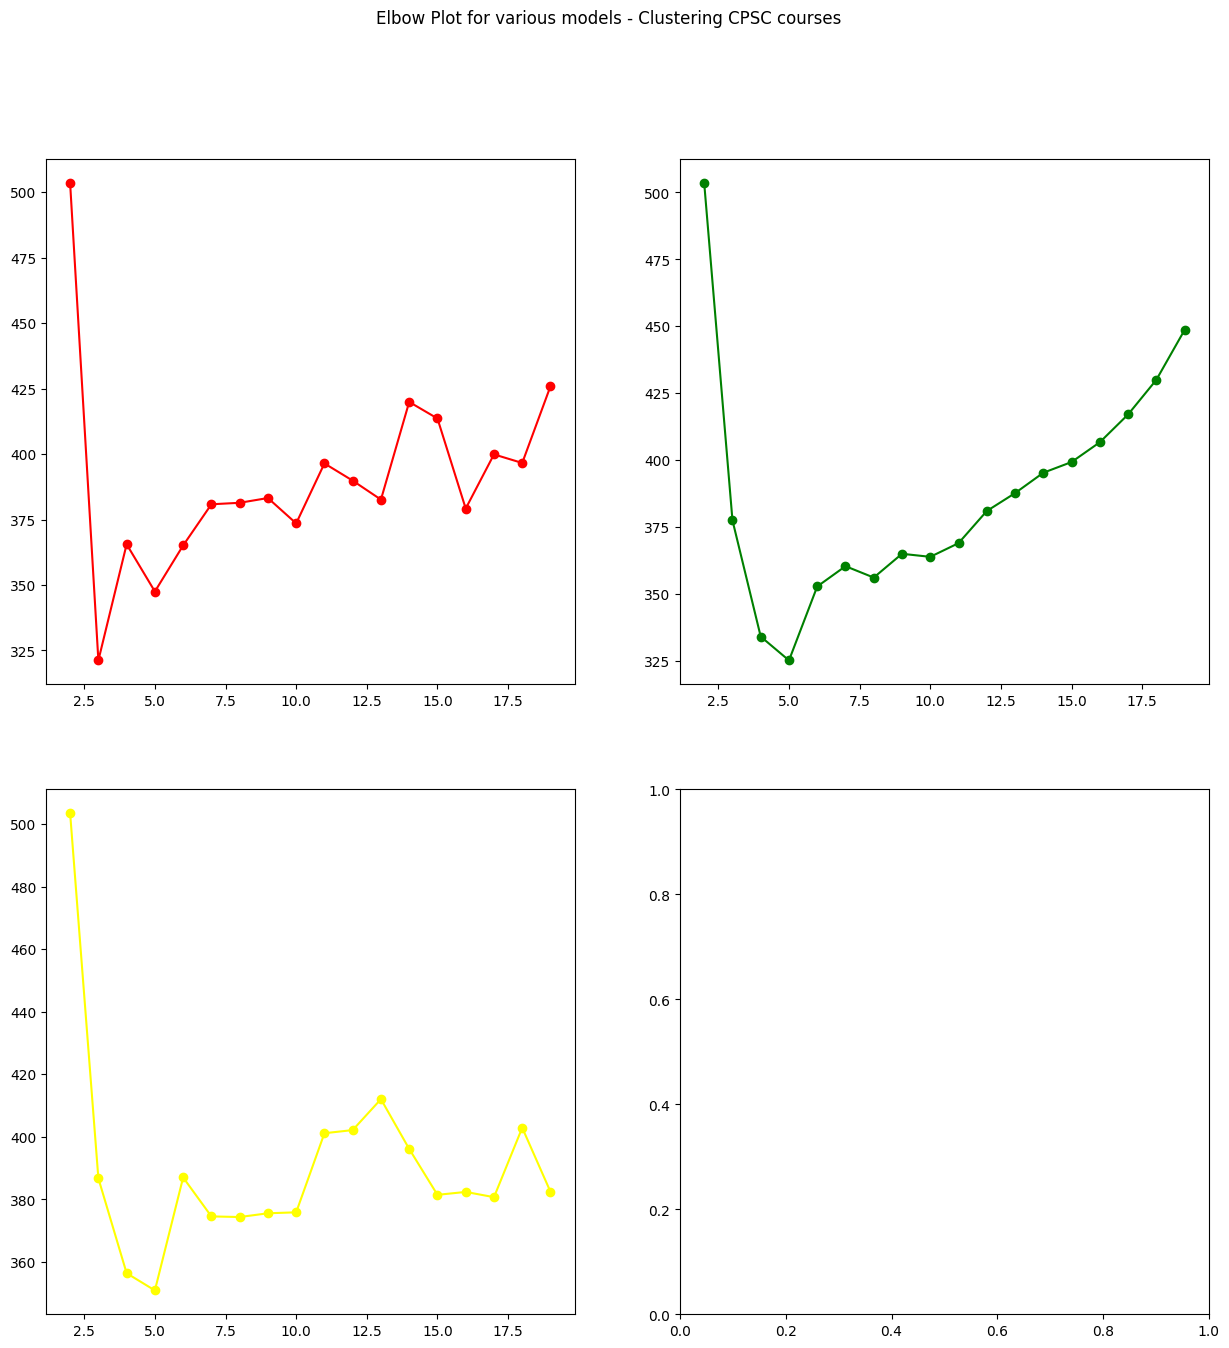

In [178]:
from sklearn.manifold import TSNE
pca_3 = TSNE(n_components=2)
pca_description_3 = pca_3.fit_transform(vectorized_description)

pca_search(pca_description_3)

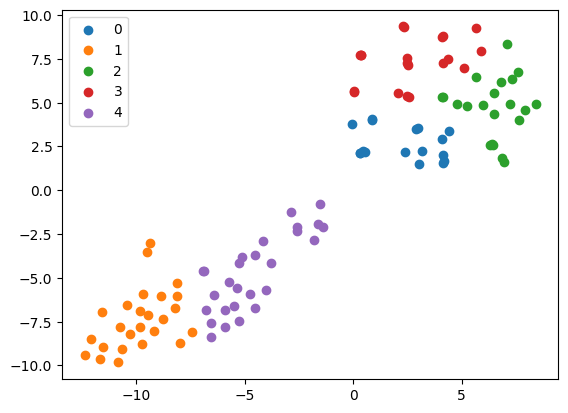

In [179]:
kmeans_, with_label_ = return_optimal(SpectralClustering(n_clusters=5, affinity="nearest_neighbors", random_state=18), pca_description_3)

In [180]:
#initial, final dimensions
print(f"Initial dimension: {vectorized_description.shape[1]}.")
print(f"Final dimension: {pca_description.shape[1]}.")

Initial dimension: 714.
Final dimension: 65.


In [181]:
with_label_2

,code,name,description,prereq,0
0,CPSC_V 100,Computational Thinking,Meaning and impact of computational thinking. ...,CPSC_107 APSC_160,1
1,CPSC_V 103,Introduction to Systematic Program Design,Computation as a tool for systematic problem s...,APSC_160 CPSC_110,1
2,CPSC_V 107,Systematic Program Design,Fundamental computation and program structures...,CPSC_103,2
3,CPSC_V 110,"Computation, Programs, and Programming",Fundamental program and computation structures...,NA,6
4,CPSC_V 121,Models of Computation,Physical and mathematical structures of comput...,CPSC_107,1
...,...,...,...,...,...
105,CPSC_V 554,Topics in Human-Computer Interaction,Topics in Human-Computer Interaction,NA,3
106,CPSC_V 564,Data Mining,Data Mining,NA,6
107,CPSC_V 589,M.Sc. Major Essay,M.Sc. Major Essay,NA,6
108,CPSC_V 590,Research Methods in Computer Science,Research Methods in Computer Science,NA,3


# Pre-requisites

In [182]:
vectorized_prereqs

array([[ 4.89906354, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [ 4.49046153, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       ...,
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263]])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#dimensionality reduction can be computationally expensive.

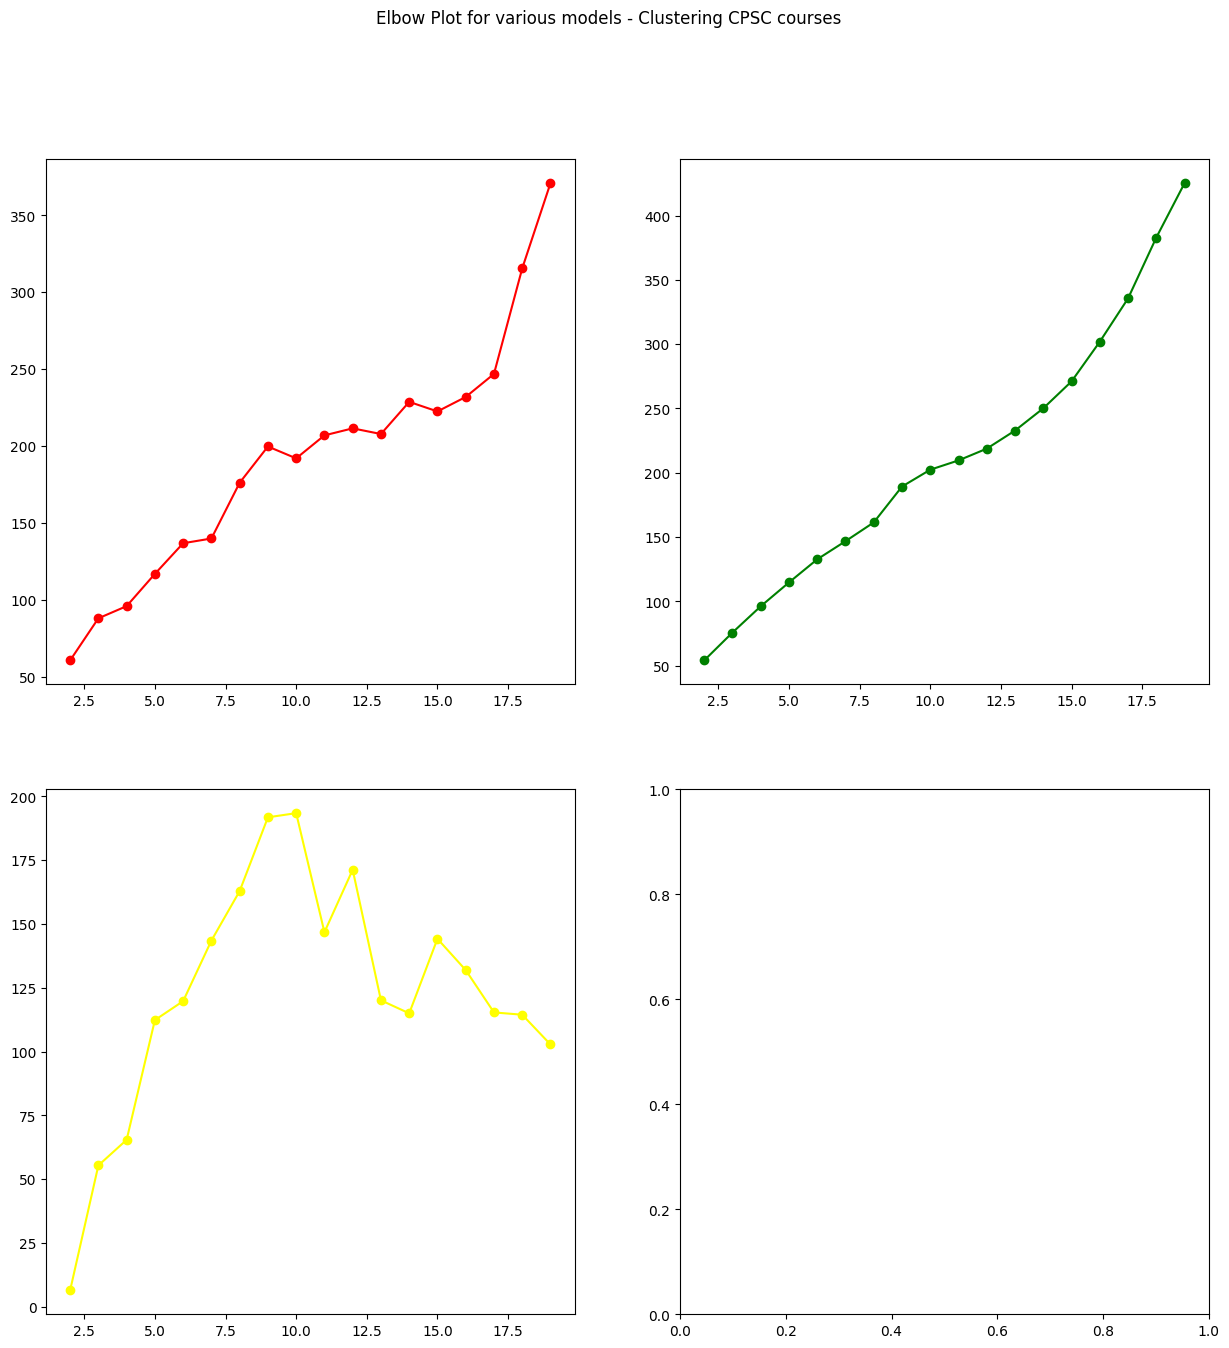

In [183]:
pca_reqs = TSNE(n_components=2)
pca_prereqs = pca_reqs.fit_transform(vectorized_prereqs)

pca_search(pca_prereqs)

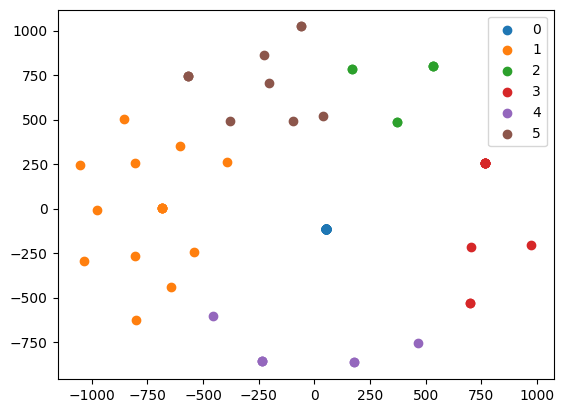

In [184]:
kmeans_3,with_label_3 = return_optimal(KMeans(n_clusters=6, init="k-means++", random_state=18, max_iter=500), pca_prereqs)

# Recommendation

In [198]:
def recommend(keyword, by_desc, by_req, pca_model, cluster_model):
    try:
        if len(keyword) > 0:
            input = pd.Series(keyword.lower())
            if by_desc:
                processed = pca_model.transform(tfv.transform(input))
                pred = cluster_model.predict(processed)[0]
                print(f"Belongs to: {pred}-th cluster.")
                print(with_label_2[with_label_2[0] == pred].sample(3)[["code", "name"]])
            elif by_req:
                pred = cluster_model.predict(processed)[0]
                print(f"Belongs to: {pred}-th cluster.")
                print(with_label_3[with_label_3[0] == pred].sample(3)[["code", "description"]])
        else:
            raise Exception("No input")
    except Exception as err:
        print(err)

In [199]:
#Co-op courses
recommend("Approved and supervised technical work experience", True, False, pca_2, kmeans_2)

Belongs to: 8-th cluster.
            code                           name
59   CPSC_V 499   Co-operative Work Placement V
28   CPSC_V 349        Honours Research Seminar
103  CPSC_V 549                 Master's Thesis


In [200]:
#Software courses
recommend("software engineering", True, False, pca_2, kmeans_2)

Belongs to: 6-th cluster.
            code                                          name
106  CPSC_V 564                                    Data Mining
100  CPSC_V 546                         Numerical Optimization
76   CPSC_V 519   Logic Programming and Functional Programming


In [201]:
#CV & Animation
recommend("animation graphics computer",True, False, pca_2, kmeans_2)

Belongs to: 3-th cluster.
            code                                     name
108  CPSC_V 590      Research Methods in Computer Science
87   CPSC_V 532         Topics in Artificial Intelligence
92   CPSC_V 537   Topics in Coding and Information Theory


In [204]:
#doent work
recommend("voronoi markov abstraction",True, False, pca, kmeans)

Belongs to: 7-th cluster.
           code                                             name
23  CPSC_V 320        Intermediate Algorithm Design and Analysis
42  CPSC_V 421               Introduction to Theory of Computing
51  CPSC_V 444   Advanced Methods for Human Computer Interaction


In [203]:
#ML courses
recommend("Machine learning",True, False, pca_2, kmeans_2)

Belongs to: 5-th cluster.
            code                        name
104  CPSC_V 550          Machine Learning II
95   CPSC_V 540             Machine Learning
79   CPSC_V 522   Artificial Intelligence II


In [205]:
#Courses that has CPSC_221 as pre-reqs.
with_label_3[with_label_3["prereq"].str.find("CPSC_221") != -1]

'numpy.ndarray' object has no attribute 'transform'


In [206]:
#Courses that has CPSC_210 as pre-reqs.
with_label_3[with_label_3["prereq"].str.find("CPSC_107") != -1]

'TSNE' object has no attribute 'transform'
